In [27]:
from toolbox import *
from music21 import *


In [28]:
file = converter.parse('stalker.mid')


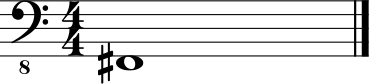

<music21.stream.Part 0x7f69808b5fd0>

In [29]:
file.parts[3].measure(77).show()
file.measure(53).parts[2]

In [30]:
def get_entropy_from_measure(file,track,measure):
    E_p = get_pitches(file.measure(measure).parts[track])
    E_r = get_rhythm(file.measure(measure).parts[track])
    E_s = get_rests(file.measure(measure).parts[track])
    total_entropy = get_list_entropy(E_p) + get_list_entropy(E_r)+ get_list_entropy(E_s)
    return total_entropy

In [50]:
import random 
a = []
for i in range(17):
    for j in range(1,78):  
        a.append(get_entropy_from_measure(file,i,j))
print(max(a))

4.737634986607822


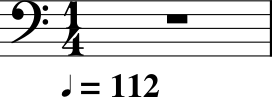

In [32]:
file.measure(1).parts[2].show()

In [89]:
def get_entropy_dict(file):
    entropy_dict = {}
    for j in range(1,max_num_measures(file)+1):
        for i in range(len(file.parts)):
            if file.parts[i].measure(j) != None:
                entropy_dict[i,j] = get_entropy_from_measure(file,i,j)
    return entropy_dict

t0= time.time()
entropy_dict = get_entropy_dict(file)
t1 = time.time() - t0
print(t1)

AttributeError: module 'time' has no attribute 'clock'

In [127]:
# for key in entropy_dict.keys():
#     print(key)
entropy_dict

{(0, 1): 0.0,
 (1, 1): 0.0,
 (2, 1): 0.0,
 (3, 1): 0.0,
 (4, 1): 0.0,
 (5, 1): 0.0,
 (6, 1): 0.0,
 (7, 1): 0.0,
 (8, 1): 0.0,
 (9, 1): 0.0,
 (10, 1): 0.0,
 (11, 1): 0.0,
 (12, 1): 0.0,
 (13, 1): 0.0,
 (14, 1): 0.0,
 (15, 1): 0.0,
 (16, 1): 0.0,
 (0, 2): 0.0,
 (1, 2): 1.2730283365896256,
 (2, 2): 0.0,
 (3, 2): 0.0,
 (4, 2): 0.0,
 (5, 2): 0.0,
 (6, 2): 0.0,
 (7, 2): 0.0,
 (8, 2): 0.0,
 (9, 2): 0.0,
 (10, 2): 0.0,
 (11, 2): 0.0,
 (12, 2): 0.6931471805599453,
 (13, 2): 0.0,
 (14, 2): 0.0,
 (15, 2): 0.0,
 (16, 2): 0.0,
 (0, 3): 0.0,
 (1, 3): 1.0549201679861442,
 (2, 3): 0.0,
 (3, 3): 0.0,
 (4, 3): 0.0,
 (5, 3): 0.0,
 (6, 3): 0.0,
 (7, 3): 0.0,
 (8, 3): 0.0,
 (9, 3): 0.0,
 (10, 3): 0.0,
 (11, 3): 0.0,
 (12, 3): 0.0,
 (13, 3): 0.0,
 (14, 3): 0.0,
 (15, 3): 0.0,
 (16, 3): 0.0,
 (0, 4): 0.0,
 (1, 4): 1.2730283365896256,
 (2, 4): 0.0,
 (3, 4): 0.0,
 (4, 4): 0.0,
 (5, 4): 0.0,
 (6, 4): 0.0,
 (7, 4): 0.0,
 (8, 4): 0.0,
 (9, 4): 0.0,
 (10, 4): 0.0,
 (11, 4): 0.0,
 (12, 4): 0.0,
 (13, 4): 0.0,
 (14,

In [168]:
from pyqubo import Binary, Constraint

def max_num_measures(file):
    return max([len(p) for p in file.parts])    

def qubo_form_from(entropy_dict):
    H = 0
    for j in range(1,max_num_measures(file)+1):
        c = 0
        o = 0
        for i in range(len(file.parts)):
            if (i,j) in entropy_dict.keys():
                c += Binary(f"x_{i}_{j}")
                o += entropy_dict[i,j]*Binary(f"x_{i}_{j}")
        H += Constraint(5*(2-c)**2, f"measure_{j}") - o
    return H.compile().to_qubo()

# def qubo_form_from(file,entropy_dict):
#     H = 0
#     for j in range(1,max_num_measures(file)+1):
#         c = 0
#         o = 0
#         for i in range(len(file.parts)):
#             if file.parts[i].measure(j) != None:
#                 c += 5*Binary(f"x_{i}_{j}")
#                 o += entropy_dict[i,j]*Binary(f"x_{i}_{j}")
#         H += Constraint((2-c)**2, f"measure_{j}") - o
#     return H.compile().to_qubo()

In [169]:
import time

qubo_form = qubo_form_from(entropy_dict)



In [170]:
print(qubo_form)

({('x_8_48', 'x_8_48'): -15.0, ('x_16_76', 'x_16_76'): -15.0, ('x_6_35', 'x_6_35'): -15.0, ('x_9_67', 'x_9_67'): -16.124670289237617, ('x_7_74', 'x_7_74'): -16.410176002778353, ('x_1_65', 'x_1_65'): -16.831714734322684, ('x_3_75', 'x_3_75'): -15.0, ('x_12_66', 'x_12_66'): -15.673011667009256, ('x_11_1', 'x_11_1'): -15.0, ('x_15_12', 'x_15_12'): -15.0, ('x_13_12', 'x_13_12'): -15.0, ('x_5_11', 'x_5_11'): -15.0, ('x_4_57', 'x_4_57'): -15.0, ('x_7_33', 'x_7_33'): -16.831714734322684, ('x_14_38', 'x_14_38'): -15.0, ('x_4_21', 'x_4_21'): -15.0, ('x_10_66', 'x_10_66'): -16.791759469228055, ('x_13_68', 'x_13_68'): -15.0, ('x_8_52', 'x_8_52'): -16.428315766660045, ('x_9_49', 'x_9_49'): -15.0, ('x_10_62', 'x_10_62'): -16.791759469228055, ('x_9_58', 'x_9_58'): -15.693147180559945, ('x_7_14', 'x_7_14'): -15.0, ('x_3_26', 'x_3_26'): -15.0, ('x_7_12', 'x_7_12'): -15.0, ('x_10_70', 'x_10_70'): -16.791759469228055, ('x_12_72', 'x_12_72'): -15.0, ('x_11_38', 'x_11_38'): -16.961674803940586, ('x_16_12'

In [171]:
print(qubo_form[1])

1540.0


In [172]:
from dwave.system import EmbeddingComposite, DWaveSampler
from neal import SimulatedAnnealingSampler
import pandas as pd
sampler = SimulatedAnnealingSampler()
sampleset = sampler.sample_qubo(qubo_form[0],
                         num_reads = 100,
                         label='Example -')
# sampleset.to_pandas_dataframe()

In [183]:
solution = sampleset.first[0]
# print(solution)

search_value = 1
found_key = [key for key, value in solution.items() if value == search_value]
# print(found_key)
ij_keys = []
for key in found_key: 
    ij_keys.append(list(map(int,key.rsplit("_")[1:3])))

check_list = np.array(ij_keys)[:,1]
unique,counts = np.unique(check_list,return_counts=True)
print('The number of selected measures is {}. We are expecting {}'.format(len(found_keys),2*77)) 
print(counts)
for i in range(1,78):
    if i in unique:
        continue
    else:
        print('Measure %{} missing'%{i})
    if counts[i] != 2:
        print('Measure %{} with %{}'%{i,counts[i]})

The number of selected measures is 154. We are expecting 154
[2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2]


In [191]:
a = np.array(ij_keys)
# print(a)
a_sorted = sorted(ij_keys, key=lambda element: (element[1])) 